Contact : dhilip@iitrpr.ac.in <br>

    - Apoorv Kushwaha & Dr. T.J. Dhilip Kumar
        Quantum Dynamics Lab (410), IIT Ropar.

## 4D SF expansion code for 2 rigid rotors:


### ***The steps to install anaconda and libraries are given below. (Pyshtools Requires: Python >=3.6)***
1. Install anaconda from [here](https://www.anaconda.com/) 
* It is recommended to __create a new environment in anaconda to prevent any conflict__ between existing libraries and pyshtools. <br> Conflicts can take hours to resolve or may fail completely after hours of wait.
2. The library pyshtools can be installed locally using conda from this [website](https://pypi.org/project/pyshtools/). 
2. Open command prompt and enter *(One time only)*:
    1. conda create -n pysh *--creates a new clean environment pysh--*
    2. conda activate pysh *--activates the environment pysh--*
    3. conda install -c conda-forge pyshtools *--installs the pyshtools library inside pysh environment--*
    3. conda install -c conda-forge tqdm (optional, read below)
3. After installation open command prompt and enter. 
    4. conda activate pysh
    5. jupyter-notebook *--Opens jupyter notebook. Now locate the required notebook in jupyter and run--* 
* The needed __time for computing spherical harmonics term is large (several hours)__. <br> Therefore, do not run the file in google colab but preferebly run locally by installing anaconda.
4. [tqdm](https://pypi.org/project/tqdm/#installation) shows progress for any loop __(optional but useful)__


#### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from math import sin, cos, radians
from sympy.physics.wigner import clebsch_gordan

In [2]:
import pyshtools as pysh

In [3]:
from tqdm.notebook import tqdm
import time

#### Importing input 4D PES file (E_4D_ml.csv) with descriptors as R $,\phi, \theta_2, \theta_1$ and E.

In [4]:
df_inp = pd.read_csv('E_4D_ml.dat',header=None,sep=',',names=['R','phi','th2','th1','E']) 
df_inp.sort_values(by = [ 'R','phi','th2','th1'], inplace=True, ascending = True)
df_inp.reset_index(inplace=True, drop = True)  # sorting by R, phi, th2 and th1 and reindexing

# Use below code to convert Hartree in cm^{-1}. 
#E_inf = 186.5889233299                         # Set Asymptotic (R) energy
#df_inp['E'] = (df_inp['E'] + E_inf)*219474.63  # converting to cm-1

In [5]:
df_inp[:10]  #printing df_inp to see input file. 

,R,phi,th2,th1,E
0,2.5,0,0,0,424269.734133
1,2.5,0,0,5,388498.719923
2,2.5,0,0,10,340211.878634
3,2.5,0,0,15,272477.951152
4,2.5,0,0,20,209709.303506
5,2.5,0,0,25,147938.716319
6,2.5,0,0,30,98040.468659
7,2.5,0,0,35,62017.800061
8,2.5,0,0,40,37613.339351
9,2.5,0,0,45,22924.169607


### Creating the matrix contining angular coordinates (should be same as the input angular terms) 
* This part can be avoided by also extracting angular terms from df_inp dataframe and converting to numpy. 
* The important part is to note that input energies must be sorted by R followed by $\phi, \theta_2$ and $\theta_1$. 

In [6]:
angmat = np.zeros((1,3))             # initializing matrix with zero
for i in range (0,91,5):             # loop for phi
    for j in range (0,91,5):         # loop for theta2   
        for k in range(0,181,5):     # loop for theta1
            ang = np.matrix([i,j,k])
            angmat = np.append(angmat,ang,axis=0)
angmat = np.delete(angmat,0,0)       # deleting the first row (all terms in row are zero)
print("Number of angular terms: ", len(angmat))
print("Angular terms: \n", angmat)

Number of angular terms:  13357
Angular terms: 
 [[  0.   0.   0.]
 [  0.   0.   5.]
 [  0.   0.  10.]
 ...
 [ 90.  90. 170.]
 [ 90.  90. 175.]
 [ 90.  90. 180.]]


### Creating the matrix contining order of radial terms $\lambda_1, \lambda_2, \& \ \lambda $
* replace step size 2 with 1 (in for loops) in case of non-symmetric molecules. 

In [7]:
Lmat = np.zeros((1,3))
L1max = 12                          # max order for radial term (NCCN)
L2max = 6                           # max order for radial term (H_2)
for i in range(0,L1max+1,2):        # loop for Lambda_1 
    for j in range(0,L2max+1,2):    # loop for Lambda_2 
        for k in range(abs(i-j),abs(i+j)+1,2):    # loop for Lambda 
            Lc = np.matrix([i,j,k])
            Lmat = np.append(Lmat,Lc,axis=0)
Lmat = np.delete(Lmat,0,0)
Lmat = Lmat.astype(int)
print("Number of radial terms: ", len(Lmat))
#print("Radial terms: \n", Lmat)

Number of radial terms:  92


* Adding a column with series of whole number (0-91) to identify terms in Lmat matrix.

In [8]:
num   = np.arange(len(Lmat))
num2  = np.reshape(num, (-1, 1))
Lmat1 = np.append(num2,Lmat,axis=1)
Lmat1[90]

matrix([[90, 12,  6, 16]])

#### Initializing required variables
* **BiSp:** bispherical harmonics coefficient = $Y_lm(\theta_1,0) * Y_lm(\theta_2,\phi) *$ CG coefficient

In [9]:
lm = len(Lmat)               # number of lambda (radial) terms
ngm = len(angmat)            # number of angular terms
px = np.zeros((ngm,lm))      # initializing matrix to store BiSp coefficients
#px1 = np.zeros((ngm,lm))      # extra variable for testing purpse
Rpt=77                       # number of radial (R) terms
f = np.zeros(ngm)            # 1D matrix to store energies
V_nf = np.zeros((Rpt,lm))    # 1D matrix to store least sq. fit terms
#V_nf1 = np.zeros((Rpt,lm))    # extra variable for testing purpse
r1 = np.arange(2.5,9.0,0.1)  # creating R row with 0.1 Ang. step size
r2 = np.arange(9,21,1)       # creating R row with 1 Ang. step size
x_dummy= np. append(r1, r2, 0)    # merging two rows to create final R coordinates

## Function to calculate bispherical harmonics coefficients (using Pyshtools)
$\sum_{m=0}^{l_m}\left\langle\lambda_{1}, m, \lambda_{2},-m \mid \lambda, 0\right\rangle\left(\frac{2 \lambda+1}{4 \pi}\right)^{1 / 2}\times Y_{\lambda_1}^{m}\left(\theta_1, 0\right) Y_{\lambda_2}^{-m}\left(\theta_2, \phi\right)$

In [10]:
def Bispher_SF2(L1,L2,L,phi,theta2,theta1):
    Total=0
    M_max= min(L1,L2)
    U00 = np.sqrt((2*L+1)/(4*np.pi))
    mu=0
    while (mu<=M_max):
        U1 = clebsch_gordan(L1, L2, L, mu, -mu, 0).evalf()
        Y1 = pysh.expand.spharm_lm (L1, mu, theta1, 0, 'unnorm', 'real', -1, True)
        Y2 = pysh.expand.spharm_lm (L2, -mu, theta2, phi, 'unnorm', 'real', -1, True)
        Total += (U1)*(Y1)*(Y2) # all even lambdas
        mu+=1
    Total=Total*U00
    return Total

#### Running loop over full range of angular terms to calculate bispherical harmonics coefficients
* px stores the bispherical harmonics coefficients and C_inv stores the pseudo_inverse of the same.
* Thus V_lambda coefficients (and pseudo-inverse) are available for all combination of thetas and phi (sorted)
* The pseudo-inverse is multiplied by E values at each R point (for all angular coordinates sorted similarly)<br>
_Solving by least sq. fit will have a form given below which is more intuitive (but equivalent to pseudoinverse)_<br>
 <span style="color:red">V_n1 = np.linalg.lstsq(px3, f, rcond=None)[0]</span> <span style="color:green">_#--pseudoinverse = least sq. fit (Moore–Penrose inverse)_</span>.

In [ ]:
for j2 in tqdm(range (ngm), desc="Angular Term: ", position=0, colour="darkorchid"):
    phi, th2, th1 = angmat[j2,0],angmat[j2,1],angmat[j2,2]
    for j3 in tqdm(range (lm), desc="Radial Term: ", position=1, leave=False, colour="limegreen"):
        L1,L2,L = Lmat[j3,0],Lmat[j3,1],Lmat[j3,2]
        pxc = Bispher_SF2(L1,L2,L, phi, th2, th1) 
        px[j2,j3]=pxc   

In [ ]:
#np.save("BiSp.npy", px)    # save Bispherical Harmonics coefficients to numpy readable file for future use

In [12]:
C_inv = np.linalg.pinv(px)

In [13]:
for i in range (Rpt):           # loop over all R 
    ct = i*ngm                  # counter
    f = df_inp.E[ct:ct+ngm]
    V_n1 = C_inv@(f)
    V_nf[i,:] = V_n1

a12 = np.arange(lm)             # a12 has same ordering as Lmat1
df_Vnf = pd.DataFrame(V_nf, columns = a12)
#df_Vnf   # prints V_lambda coefficients with Lmat1 ordering (print Lmat1 to match radial coefficient)

In [14]:
df_Vnf[15:30] # view minima region 

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
15,546.628721,42.753663,1.310698,0.503661,1405.869047,-119.138717,45.606409,-2.697921,3.383048,-1.943828,...,-8.086395,8.162983,-10.364661,5.552625,-3.864505,3.341922,-3.101975,3.032813,-3.178092,4.125276
16,302.096729,27.604304,0.928265,0.356107,952.920901,-145.527322,61.218824,-21.928804,1.467660,-0.826667,...,-5.610826,5.661348,-7.184072,3.812538,-2.653199,2.294126,-2.129054,2.081146,-2.180286,2.829271
17,136.735889,16.748322,0.649819,0.246439,632.342680,-159.847752,70.267525,-34.352127,0.193571,-0.080051,...,-3.857359,3.889791,-4.932282,2.588477,-1.801140,1.557119,-1.444759,1.411859,-1.478626,1.918032
18,27.435084,9.041698,0.447801,0.165230,407.215096,-165.685384,74.676341,-41.892499,-0.627562,0.403868,...,-2.623142,2.643161,-3.348217,1.733915,-1.206311,1.042643,-0.967120,0.944745,-0.988984,1.282240
19,-42.482906,3.639233,0.301877,0.105393,250.651244,-165.660051,75.852360,-45.962868,-1.131648,0.703118,...,-1.760849,1.772474,-2.242290,1.142711,-0.794820,0.686766,-0.636760,0.621711,-0.650428,0.842718
20,-85.006966,-0.083003,0.197056,0.061598,143.113290,-161.678431,74.821026,-47.597920,-1.416372,0.873950,...,-1.163743,1.169799,-1.477169,0.738202,-0.513294,0.443315,-0.410796,0.400797,-0.418950,0.542285
21,-108.716878,-2.585131,0.122292,0.029835,70.439601,-155.121055,72.326213,-47.552907,-1.551610,0.956739,...,-0.754713,0.757169,-0.953658,0.465194,-0.323308,0.279046,-0.258356,0.251799,-0.262873,0.339782
22,-119.719592,-4.206034,0.069455,0.007080,22.395475,-146.980833,68.904335,-46.376849,-1.587059,0.980312,...,-0.478231,0.478443,-0.600337,0.284105,-0.197305,0.170121,-0.157299,0.153057,-0.159480,0.205696
23,-122.333481,-5.194909,0.032566,-0.008944,-8.390452,-137.965638,64.939202,-44.466745,-1.557812,0.965119,...,-0.294461,0.293353,-0.365985,0.166670,-0.115610,0.099517,-0.091820,0.089106,-0.092554,0.118960
24,-119.587551,-5.734628,0.007233,-0.019951,-27.205896,-128.574220,60.702617,-42.107703,-1.488433,0.925550,...,-0.174948,0.173138,-0.214026,0.092814,-0.064245,0.055144,-0.050690,0.048964,-0.050580,0.064612


In [15]:
df_Vnf.to_csv('12-6_Vlam_Ylm.dat', index=None, header=True,
                sep=' ')    # save V_lam coefficients to file

In [18]:
# Read V_lam coefficients from file
df_Vnf = pd.read_csv('12-6_Vlam_Ylm.dat',sep=' ',header=None)
df_Vnf.drop(0,inplace= True)
df_Vnf

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
1,129071.117428,5881.907935,1.437689e+02,4.557644e+01,201328.696241,18175.056407,-9793.196827,9830.334362,1.047189e+03,-5.936741e+02,...,-1.119613e+03,1.132488e+03,-1.441503e+03,8.157036e+02,-5.679086e+02,4.913520e+02,-4.563710e+02,4.465685e+02,-4.684392e+02,6.087785e+02
2,94069.089242,4342.855263,1.061698e+02,3.404586e+01,147564.915991,13247.801417,-7148.943051,7206.460141,7.627804e+02,-4.329550e+02,...,-8.196917e+02,8.290887e+02,-1.055272e+03,5.963450e+02,-4.151849e+02,3.592135e+02,-3.336366e+02,3.264660e+02,-3.424489e+02,4.450338e+02
3,68406.981262,3203.677349,7.836383e+01,2.543725e+01,108017.839613,9613.776259,-5198.248077,5268.408548,5.542465e+02,-3.149976e+02,...,-5.993222e+02,6.061682e+02,-7.714998e+02,4.353270e+02,-3.030798e+02,2.622192e+02,-2.435457e+02,2.383077e+02,-2.499699e+02,3.248440e+02
4,49616.686552,2360.714264,5.780535e+01,1.900683e+01,78952.079563,6937.064567,-3760.911945,3838.145520,4.015489e+02,-2.285314e+02,...,-4.375514e+02,4.425288e+02,-5.631969e+02,3.172547e+02,-2.208750e+02,1.910952e+02,-1.774843e+02,1.736641e+02,-1.821587e+02,2.367148e+02
5,35878.257475,1737.161372,4.260966e+01,1.420097e+01,57609.534967,4968.737464,-2703.419733,2783.758552,2.899085e+02,-1.652394e+02,...,-3.189182e+02,3.225289e+02,-4.104493e+02,2.307736e+02,-1.606649e+02,1.390014e+02,-1.290990e+02,1.263176e+02,-1.324930e+02,1.721690e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-0.001241,-0.000161,-1.251525e-06,-1.497392e-06,-0.000471,-0.002241,0.001068,-0.000778,-1.887862e-05,1.313190e-05,...,-5.067166e-06,5.107295e-06,-6.462156e-06,4.557117e-06,-3.169560e-06,2.738791e-06,-2.539973e-06,2.481303e-06,-2.598545e-06,3.372396e-06
74,-0.000456,-0.000059,-4.604092e-07,-5.508624e-07,-0.000173,-0.000825,0.000393,-0.000286,-6.944995e-06,4.830926e-06,...,-1.864164e-06,1.878928e-06,-2.377370e-06,1.676517e-06,-1.166049e-06,1.007574e-06,-9.344304e-07,9.128465e-07,-9.559786e-07,1.240671e-06
75,-0.000168,-0.000022,-1.693749e-07,-2.026513e-07,-0.000064,-0.000303,0.000145,-0.000105,-2.554913e-06,1.777194e-06,...,-6.857956e-07,6.912268e-07,-8.745956e-07,6.167627e-07,-4.289700e-07,3.706695e-07,-3.437613e-07,3.358210e-07,-3.516886e-07,4.564222e-07
76,-0.000062,-0.000008,-6.230954e-08,-7.455130e-08,-0.000023,-0.000112,0.000053,-0.000039,-9.398988e-07,6.537927e-07,...,-2.522912e-07,2.542892e-07,-3.217471e-07,2.268952e-07,-1.578098e-07,1.363622e-07,-1.264632e-07,1.235421e-07,-1.293795e-07,1.679090e-07


## Below is the basic code to fit the multipole expansion terms into MOLSCAT readable functions. 

* The function given below is a sum of three Slater functions of increasing order where coefficients a, b and c are optimised based on the data.
* Use as template - A good fit will require tweaking in order and number of functions. 
    * Too many functions will overfit the data and behave poorly with high energy region 
    * Less functions will underfit the data and give poor description of minima. 

In [19]:
from scipy.optimize import curve_fit

a,b,c,d,e,f,rmsx = np.zeros(lm),np.zeros(lm),np.zeros(lm),np.zeros(lm),np.zeros(lm),np.zeros(lm),np.zeros(lm)
def exp_fit(x, a,b,c):
    return  a*np.exp(-1*x)+b*np.exp(-2*x)+c*np.exp(-3*x)

[[0 0 0]]
[-1.10241890e+04 -2.66819171e+06  2.67507419e+08]


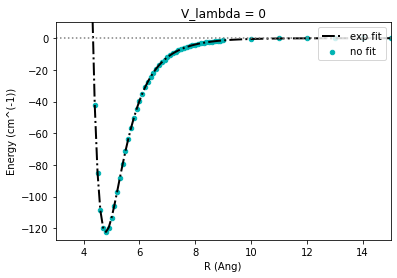

Double exponential RMSE =  2.9865551839646735e-12
[[0 2 2]]
[-1.43243431e+03  8.98392084e+03  1.07378846e+07]


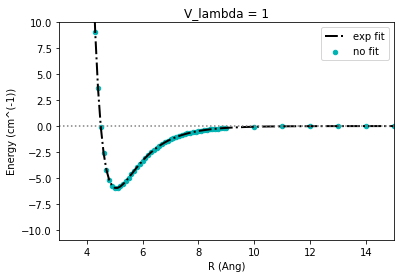

Double exponential RMSE =  2.2235181604347105e-12
[[0 4 4]]
[-1.11211483e+01 -3.56391497e+02  2.65932451e+05]


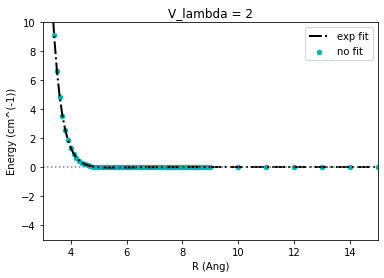

Double exponential RMSE =  4.1019468113137513e-13
[[0 6 6]]
[-1.33060923e+01  8.78430193e+02  7.36774688e+04]


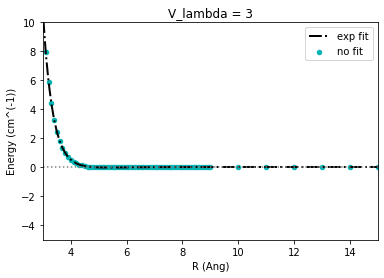

Double exponential RMSE =  5.910180344956614e-13
[[2 0 2]]
[-4.18074764e+03 -2.90828328e+06  4.00061444e+08]


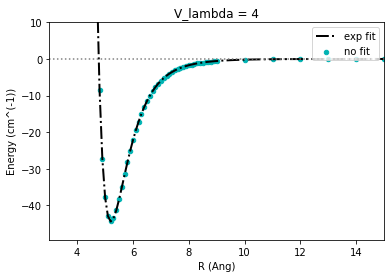

Double exponential RMSE =  1.6701340581263228e-11
[[2 2 0]]
[-1.99171260e+04  9.81826668e+04  3.46211267e+07]


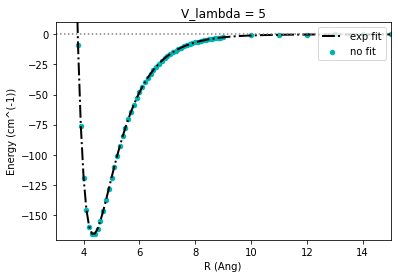

Double exponential RMSE =  8.712775956966621e-12
[[2 2 2]]
[ 9.49245591e+03 -4.14618156e+04 -1.86102123e+07]


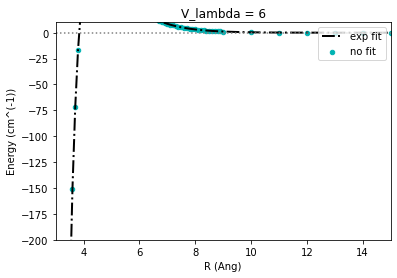

Double exponential RMSE =  2.784161048458423e-12
[[2 2 4]]
[-6.91779044e+03  3.25868002e+04  1.84033641e+07]


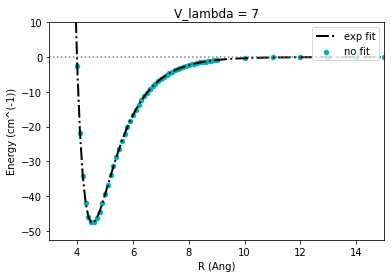

Double exponential RMSE =  5.63939057798585e-13
[[2 4 2]]
[-1.67755185e+02 -2.04542649e+04  2.16744348e+06]


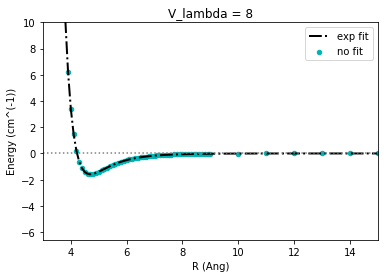

Double exponential RMSE =  1.5425666186426952e-12
[[2 4 4]]
[ 1.16690377e+02  1.00550111e+04 -1.21320148e+06]


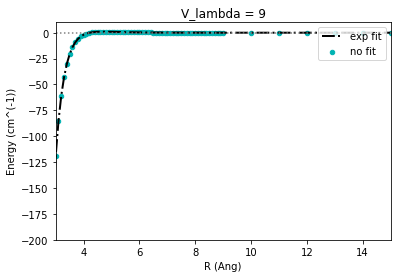

Double exponential RMSE =  4.584743075376481e-13
[[2 4 6]]
[-1.26677699e+02 -2.58961580e+03  7.41444593e+05]


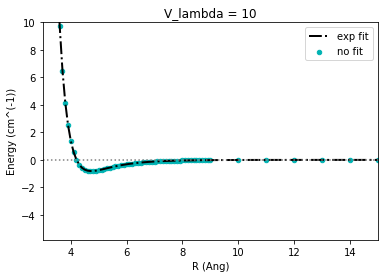

Double exponential RMSE =  3.5656411445624652e-12
[[2 6 4]]
[ 3.82386340e+00 -4.90241396e+03  4.30952292e+05]


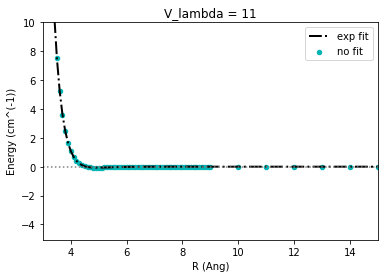

Double exponential RMSE =  2.7052382906089132e-12
[[2 6 6]]
[ 1.07372699e+01  2.75246168e+03 -3.00140909e+05]


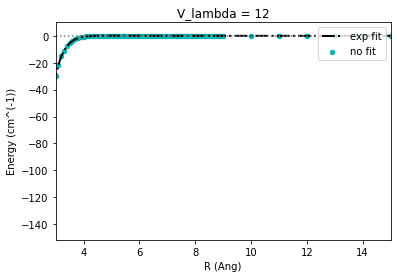

Double exponential RMSE =  1.8385136853476123e-12
[[2 6 8]]
[-3.39118572e+01 -1.44284749e+03  2.95333104e+05]


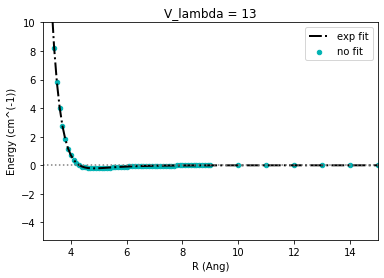

Double exponential RMSE =  1.3709208253441662e-12
[[4 0 4]]
[-3.34129686e+02 -1.32997227e+06  2.48852852e+08]


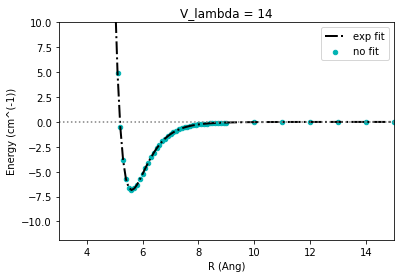

Double exponential RMSE =  1.03466872193862e-10
[[4 2 2]]
[-3.91563824e+03 -1.79820453e+05  2.21902370e+07]


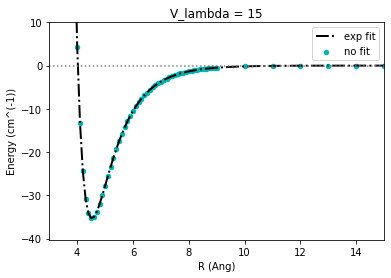

Double exponential RMSE =  7.647594061686929e-13
[[4 2 4]]
[ 2.50019129e+03  1.21160795e+05 -1.56043712e+07]


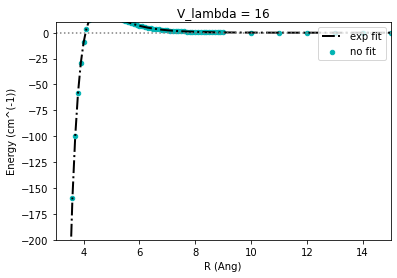

Double exponential RMSE =  1.4201376440651284e-12
[[4 2 6]]
[-2.33032309e+03 -1.15455365e+05  1.67604935e+07]


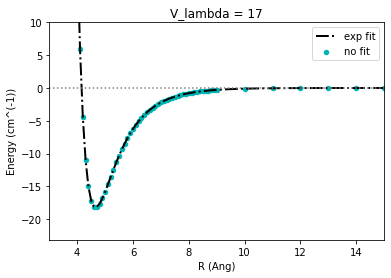

Double exponential RMSE =  7.690994362399261e-13
[[4 4 0]]
[ 2.99174395e+02 -1.23337921e+05  7.51632831e+06]


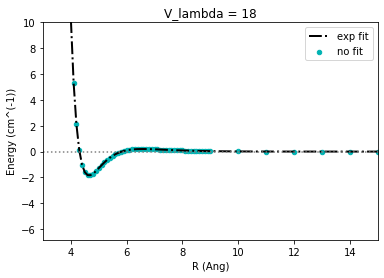

Double exponential RMSE =  1.0086738650606503e-12
[[4 4 2]]
[-1.54471522e+02  6.16717308e+04 -3.74269790e+06]


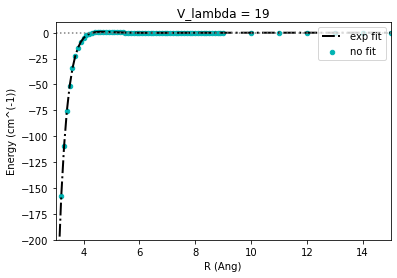

Double exponential RMSE =  3.0471208749780206e-13
[[4 4 4]]
[ 1.19632831e+02 -4.63991344e+04  2.79097915e+06]


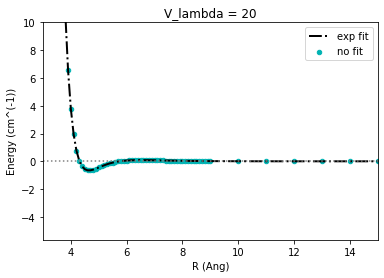

Double exponential RMSE =  5.264040459194365e-13
[[4 4 6]]
[-1.00528110e+02  3.96033975e+04 -2.35289537e+06]


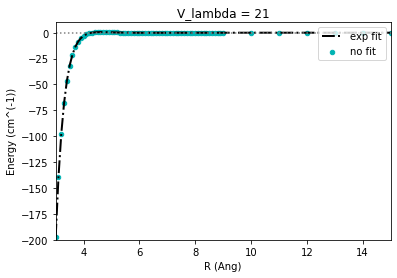

Double exponential RMSE =  1.9340617421639195e-12
[[4 4 8]]
[ 1.08062961e+02 -4.15824742e+04  2.42462898e+06]


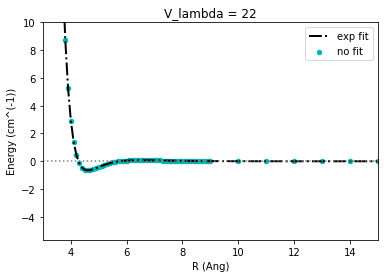

Double exponential RMSE =  9.000139446665952e-13
[[4 6 2]]
[ 2.02027458e+02 -2.18545540e+04  5.73250318e+05]


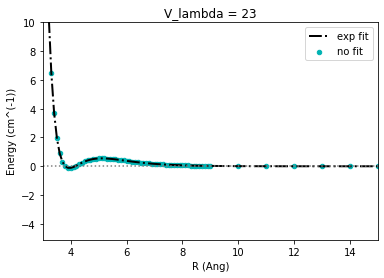

Double exponential RMSE =  2.123877231364766e-12
[[4 6 4]]
[-1.34089861e+02  1.44168472e+04 -3.78518405e+05]


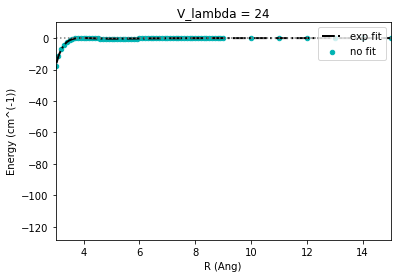

Double exponential RMSE =  1.649334113424237e-12
[[4 6 6]]
[ 1.13805525e+02 -1.21781905e+04  3.20550617e+05]


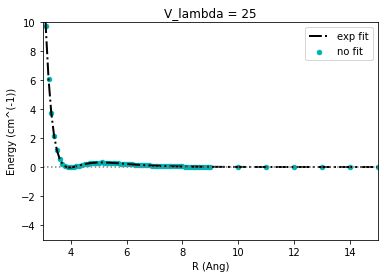

Double exponential RMSE =  2.3154695008087893e-12
[[4 6 8]]
[-1.07704328e+02  1.14975107e+04 -3.04051792e+05]


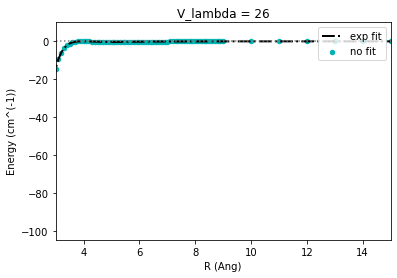

Double exponential RMSE =  5.862434959039886e-13
[[ 4  6 10]]
[ 1.28302121e+02 -1.35786410e+04  3.61280170e+05]


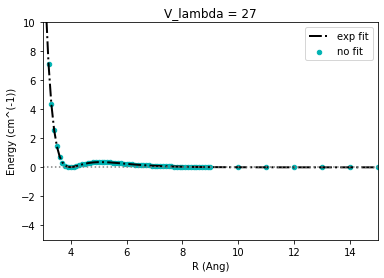

Double exponential RMSE =  7.880461548275968e-13
[[6 0 6]]
[-3.01497937e+02 -3.20954847e+05  1.00462037e+08]


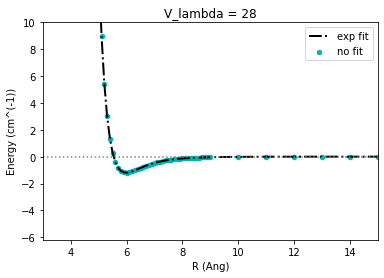

Double exponential RMSE =  1.6331954738838278e-12
[[6 2 4]]
[-2.55102353e+02 -2.45811276e+05  1.81214301e+07]


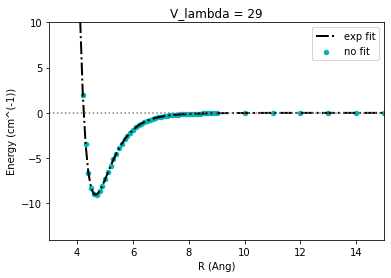

Double exponential RMSE =  2.934618113096356e-12
[[6 2 6]]
[ 1.75814349e+02  1.72978853e+05 -1.32099650e+07]


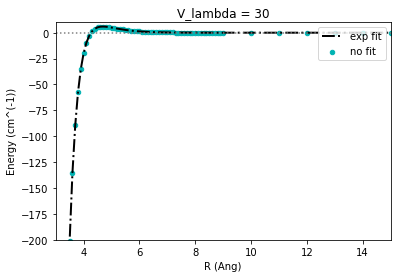

Double exponential RMSE =  1.0044427734027913e-12
[[6 2 8]]
[-1.58809436e+02 -1.81243075e+05  1.45606989e+07]


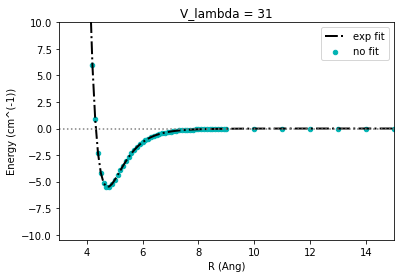

Double exponential RMSE =  1.4119138076414781e-12
[[6 4 2]]
[ 1.47317411e+02 -7.06726093e+04  4.32009174e+06]


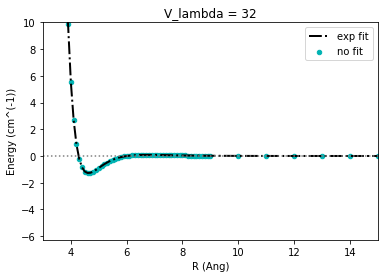

Double exponential RMSE =  3.8172886035084995e-13
[[6 4 4]]
[-9.72514451e+01  4.62468020e+04 -2.81440872e+06]


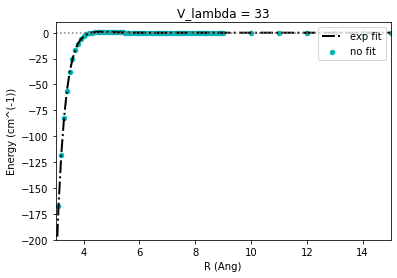

Double exponential RMSE =  3.4149083932678983e-13
[[6 4 6]]
[ 8.16764291e+01 -3.86694385e+04  2.33542072e+06]


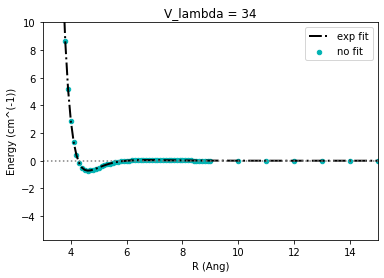

Double exponential RMSE =  2.2723075340116202e-13
[[6 4 8]]
[-7.66150378e+01  3.61742095e+04 -2.15951345e+06]


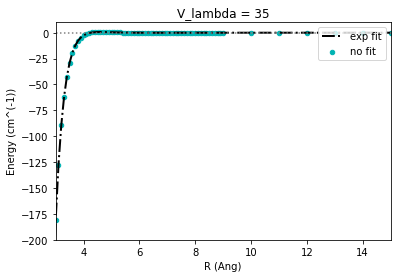

Double exponential RMSE =  9.681331514137252e-13
[[ 6  4 10]]
[ 9.29760261e+01 -4.25540162e+04  2.49738647e+06]


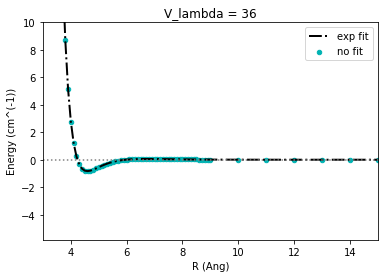

Double exponential RMSE =  6.276909607089457e-13
[[6 6 0]]
[-1.60086266e+02  2.16209315e+04 -1.53642025e+06]


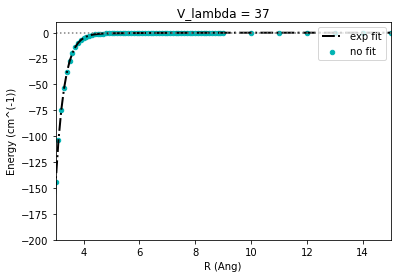

Double exponential RMSE =  2.6551195831154862e-12
[[6 6 2]]
[ 8.08680093e+01 -1.09311526e+04  7.74962084e+05]


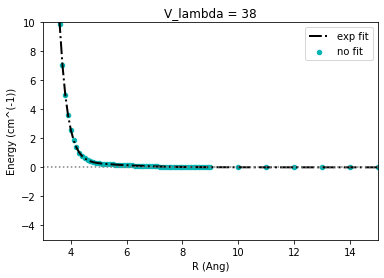

Double exponential RMSE =  5.14502863790814e-13
[[6 6 4]]
[-6.22109031e+01  8.42138686e+03 -5.93846779e+05]


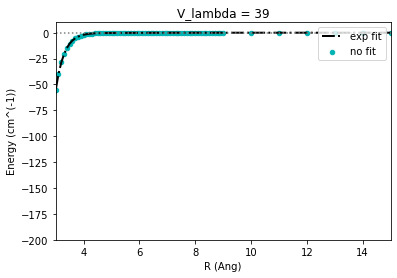

Double exponential RMSE =  1.0724812944912278e-12
[[6 6 6]]
[ 5.42062831e+01 -7.34563188e+03  5.13838295e+05]


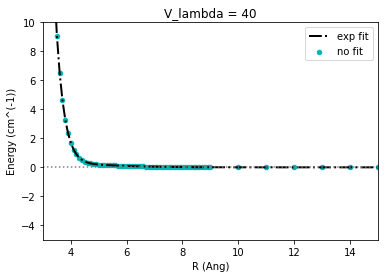

Double exponential RMSE =  2.661082324311561e-13
[[6 6 8]]
[-5.10145009e+01  6.91291669e+03 -4.78612836e+05]


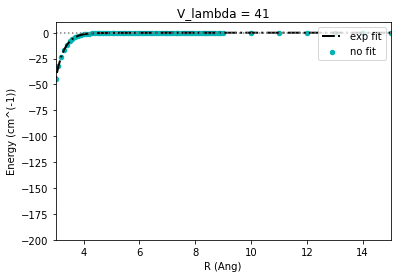

Double exponential RMSE =  2.0058477133120793e-13
[[ 6  6 10]]
[ 5.21214295e+01 -7.05869384e+03  4.82864143e+05]


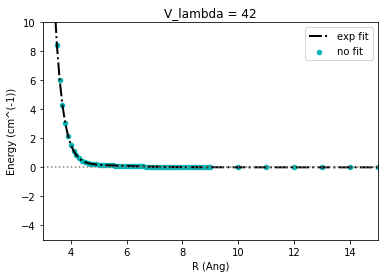

Double exponential RMSE =  6.015002398395893e-13
[[ 6  6 12]]
[-6.61778605e+01  8.97878024e+03 -6.06222475e+05]


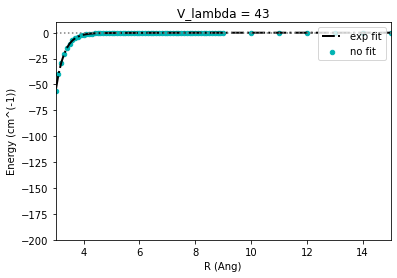

Double exponential RMSE =  1.101478384830576e-12
[[8 0 8]]
[-3.72304304e+02 -1.04703733e+04  2.52438384e+07]


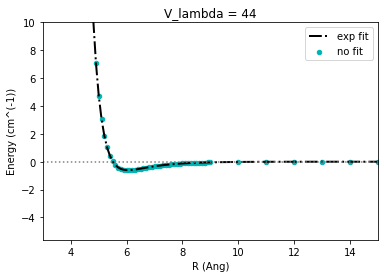

Double exponential RMSE =  7.132499620598324e-13
[[8 2 6]]
[ 1.05191701e+02 -1.45460930e+05  1.31866967e+07]


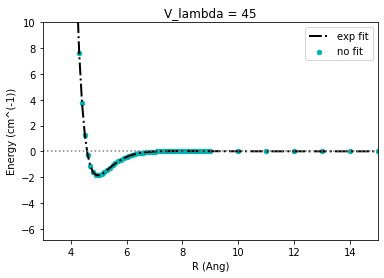

Double exponential RMSE =  5.730936924177917e-13
[[8 2 8]]
[-6.92466646e+01  1.05277759e+05 -9.77737115e+06]


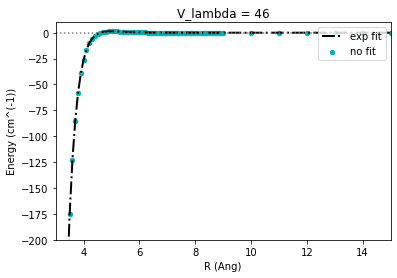

Double exponential RMSE =  5.723173229007761e-13
[[ 8  2 10]]
[ 7.21796065e+01 -1.14542021e+05  1.09319697e+07]


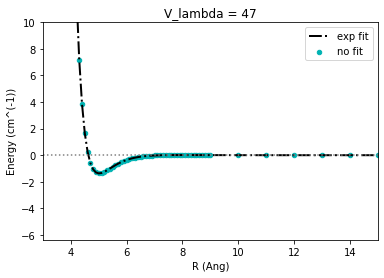

Double exponential RMSE =  1.2813556117205333e-12
[[8 4 4]]
[ 9.03919149e+00 -1.51640450e+04  9.31175465e+05]


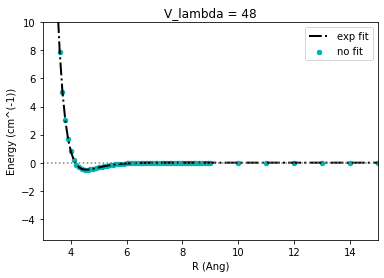

Double exponential RMSE =  3.4234125886663784e-13
[[8 4 6]]
[-5.35927763e+00  1.02338376e+04 -6.27522293e+05]


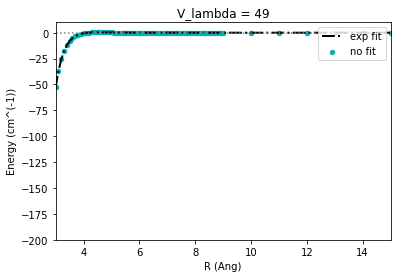

Double exponential RMSE =  3.3824353571993943e-13
[[8 4 8]]
[ 3.48771016e+00 -8.68469734e+03  5.30674952e+05]


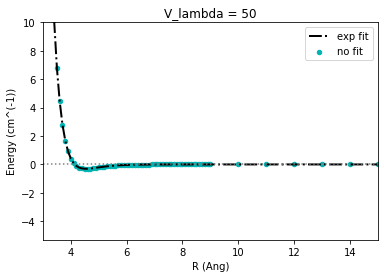

Double exponential RMSE =  2.379709605790827e-13
[[ 8  4 10]]
[-1.96526324e+00  8.19358020e+03 -4.97533288e+05]


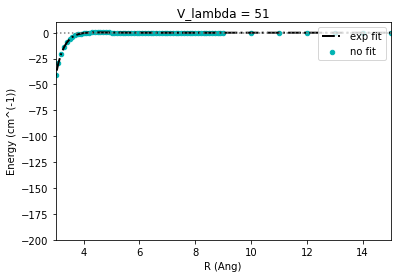

Double exponential RMSE =  1.2645479851287456e-13
[[ 8  4 12]]
[ 9.71668843e-01 -9.70637183e+03  5.84022095e+05]


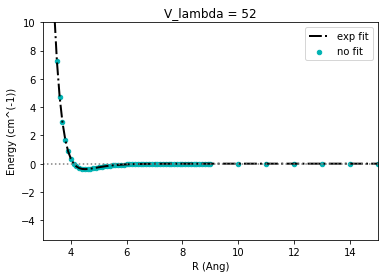

Double exponential RMSE =  4.982290968700653e-13
[[8 6 2]]
[-1.05899189e+02  2.37641041e+04 -1.44909311e+06]


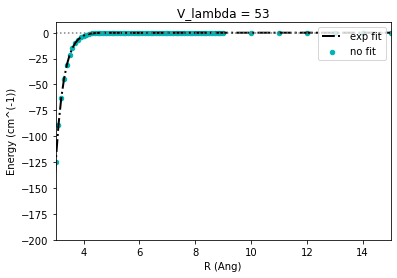

Double exponential RMSE =  1.3535215006336497e-13
[[8 6 4]]
[ 6.96530902e+01 -1.56076239e+04  9.50189295e+05]


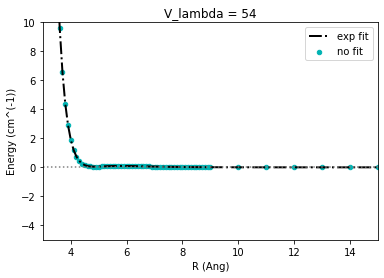

Double exponential RMSE =  2.498471787810399e-13
[[8 6 6]]
[-5.82473963e+01  1.30192441e+04 -7.90631999e+05]


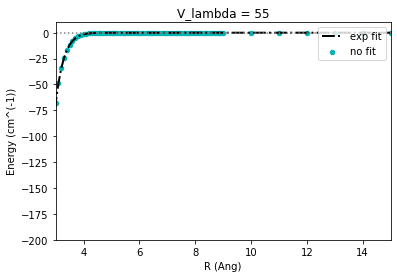

Double exponential RMSE =  3.6244449315569177e-13
[[8 6 8]]
[ 5.29767455e+01 -1.17969942e+04  7.14021419e+05]


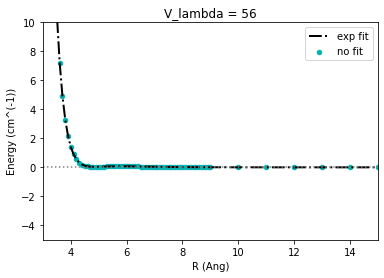

Double exponential RMSE =  2.9046826761021583e-13
[[ 8  6 10]]
[-5.11783127e+01  1.13390451e+04 -6.83474941e+05]


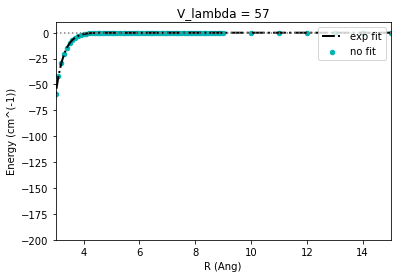

Double exponential RMSE =  3.157992283473956e-13
[[ 8  6 12]]
[ 5.32678443e+01 -1.17289431e+04  7.03525250e+05]


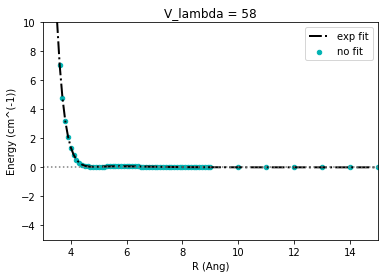

Double exponential RMSE =  3.6711088179278825e-13
[[ 8  6 14]]
[-6.88541635e+01  1.50585544e+04 -8.98152236e+05]


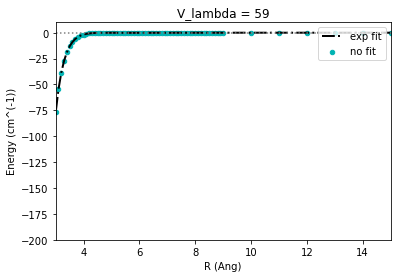

Double exponential RMSE =  2.828330207516567e-13
[[10  0 10]]
[-8.12136994e+02  3.87019230e+04  2.01940306e+06]


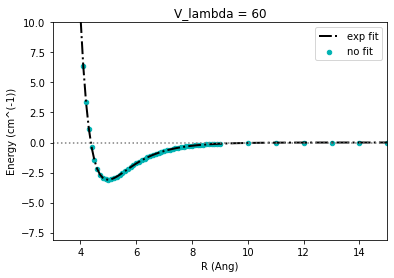

Double exponential RMSE =  1.2925202595475575e-12
[[10  2  8]]
[ 5.68706456e+01 -6.66120914e+04  8.65944234e+06]


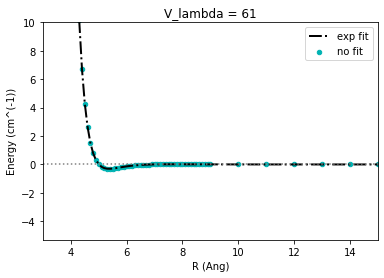

Double exponential RMSE =  5.319074607957195e-13
[[10  2 10]]
[-3.89406629e+01  4.96909833e+04 -6.53285792e+06]


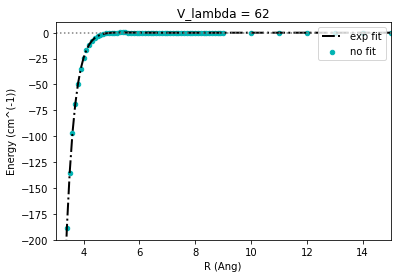

Double exponential RMSE =  2.861861389534814e-12
[[10  2 12]]
[ 3.95922697e+01 -5.57696398e+04  7.41282511e+06]


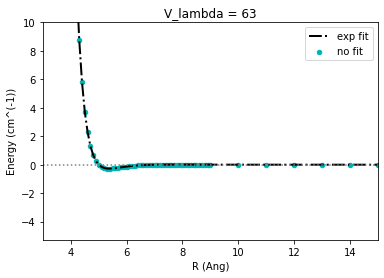

Double exponential RMSE =  8.897602093300822e-13
[[10  4  6]]
[-4.94812408e+01  1.81027603e+04 -1.66054073e+06]


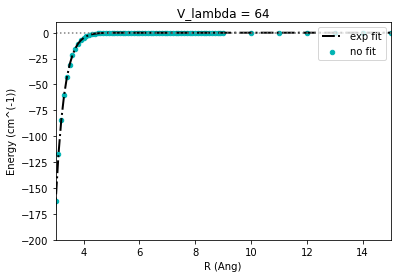

Double exponential RMSE =  2.2362584438751437e-13
[[10  4  8]]
[ 3.59348552e+01 -1.30063542e+04  1.18380892e+06]


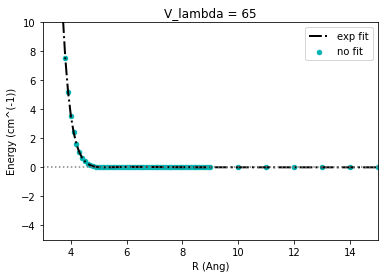

Double exponential RMSE =  5.025795413555169e-13
[[10  4 10]]
[-3.31527694e+01  1.18127923e+04 -1.06552024e+06]


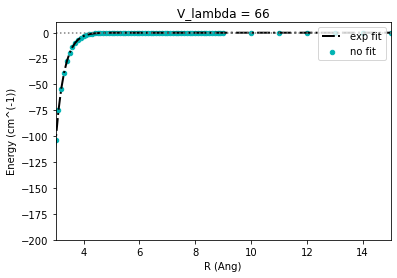

Double exponential RMSE =  5.2259480654621e-13
[[10  4 12]]
[ 3.42795951e+01 -1.19843397e+04  1.07012323e+06]


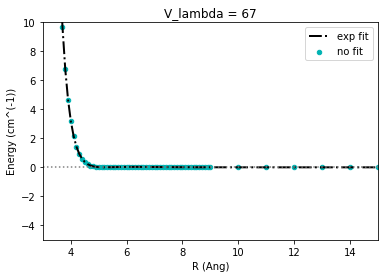

Double exponential RMSE =  1.9905456999885197e-13
[[10  4 14]]
[-4.46160655e+01  1.53211874e+04 -1.35265334e+06]


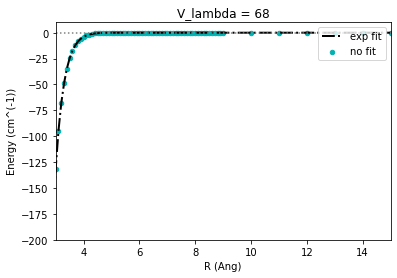

Double exponential RMSE =  8.205819889944894e-13
[[10  6  4]]
[ 5.82564548e+00  1.52082431e+03 -6.43670223e+04]


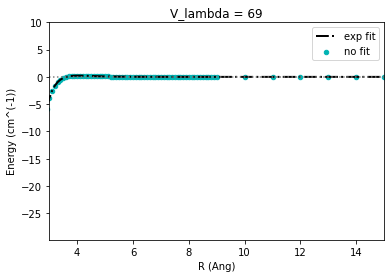

Double exponential RMSE =  1.4176069060211849e-12
[[10  6  6]]
[-3.87277944e+00 -1.05274071e+03  4.44060270e+04]


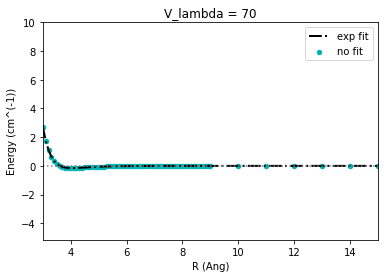

Double exponential RMSE =  5.403091449229885e-13
[[10  6  8]]
[ 3.18011165e+00  9.11387935e+02 -3.82115769e+04]


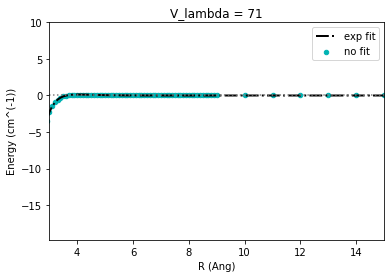

Double exponential RMSE =  6.256569403768523e-13
[[10  6 10]]
[-2.78104431e+00 -8.48982519e+02  3.52389442e+04]


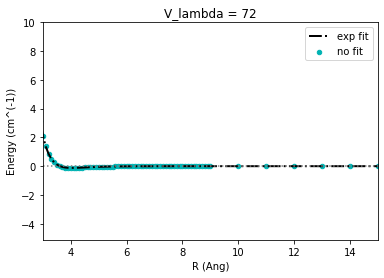

Double exponential RMSE =  4.868688995000958e-13
[[10  6 12]]
[ 2.54068046e+00  8.32164123e+02 -3.39992105e+04]


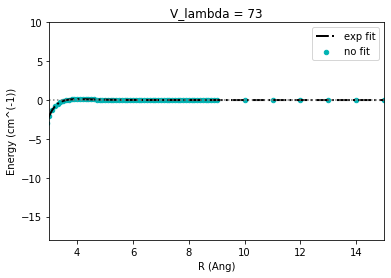

Double exponential RMSE =  6.830844048791182e-13
[[10  6 14]]
[-2.47102202e+00 -8.70556664e+02  3.47268952e+04]


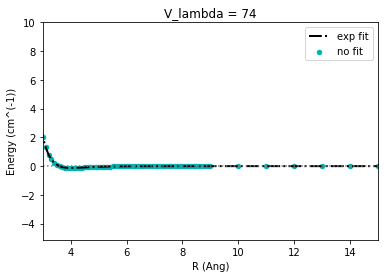

Double exponential RMSE =  4.2905269868123057e-13
[[10  6 16]]
[ 2.97124881e+00  1.12005966e+03 -4.31234239e+04]


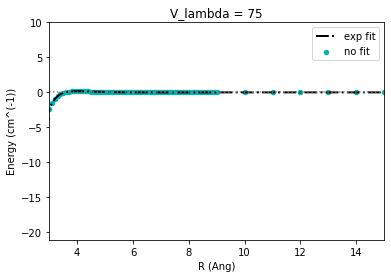

Double exponential RMSE =  5.541838540275898e-13
[[12  0 12]]
[ 5.96269461e+02 -8.51467123e+04  3.33204270e+06]


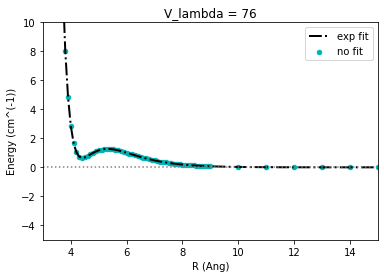

Double exponential RMSE =  8.203394464479969e-12
[[12  2 10]]
[ 4.55108627e+01 -4.47885892e+04  6.70053565e+06]


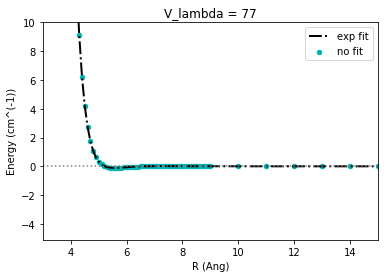

Double exponential RMSE =  2.6586725923577958e-12
[[12  2 12]]
[-3.63055020e+01  3.58618809e+04 -5.21712345e+06]


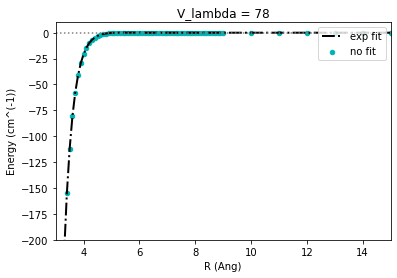

Double exponential RMSE =  4.1129435488524817e-13
[[12  2 14]]
[ 4.37106439e+01 -4.33176948e+04  6.11251510e+06]


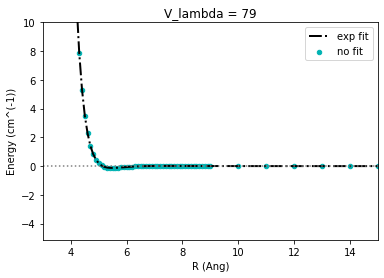

Double exponential RMSE =  1.1778054739569497e-12
[[12  4  8]]
[-6.92518718e+01  3.00094057e+04 -3.45261700e+06]


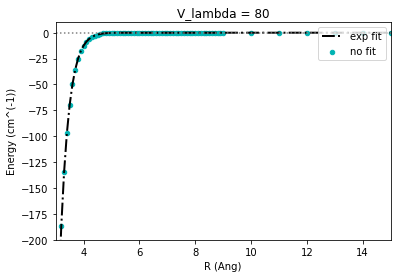

Double exponential RMSE =  7.1603181247888e-13
[[12  4 10]]
[ 4.97549199e+01 -2.16616366e+04  2.48729582e+06]


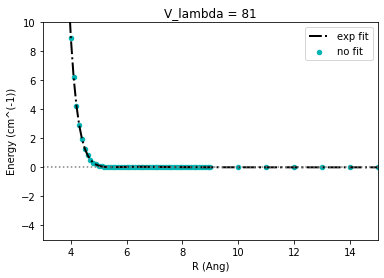

Double exponential RMSE =  1.493355937675273e-12
[[12  4 12]]
[-4.50296163e+01  1.97039522e+04 -2.25766746e+06]


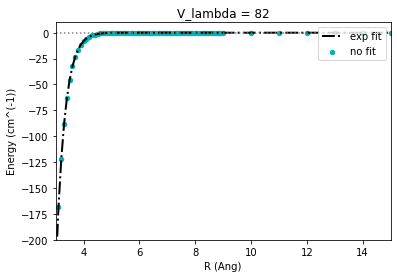

Double exponential RMSE =  8.898381999466114e-13
[[12  4 14]]
[ 4.53862332e+01 -1.99827381e+04  2.28429064e+06]


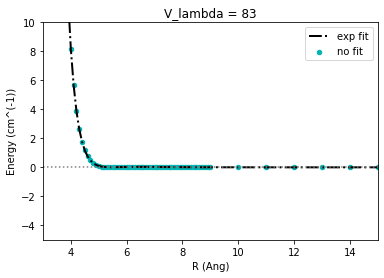

Double exponential RMSE =  2.446676640322028e-12
[[12  4 16]]
[-5.74263066e+01  2.55109384e+04 -2.90856281e+06]


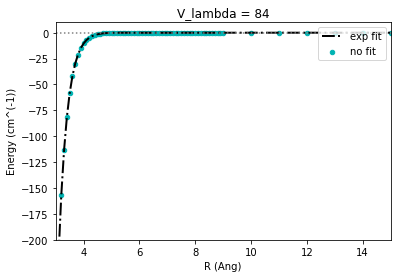

Double exponential RMSE =  1.7881576174312224e-12
[[12  6  6]]
[ 4.04968664e+01 -1.61690178e+04  1.66579536e+06]


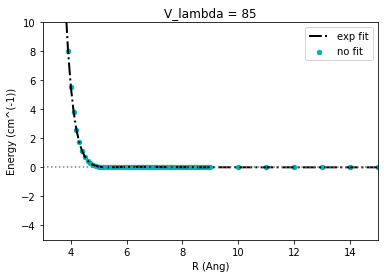

Double exponential RMSE =  1.3324898876559274e-12
[[12  6  8]]
[-2.81663272e+01  1.12604326e+04 -1.15980280e+06]


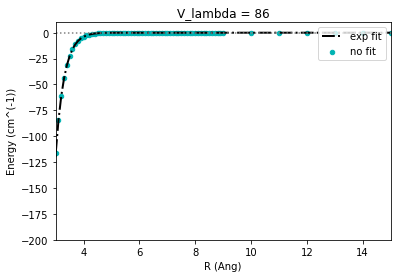

Double exponential RMSE =  2.2774554216322667e-12
[[12  6 10]]
[ 2.43382971e+01 -9.74665617e+03  1.00351172e+06]


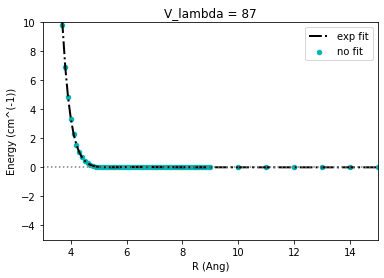

Double exponential RMSE =  8.853851162754886e-13
[[12  6 12]]
[-2.25714961e+01  9.05825287e+03 -9.32140414e+05]


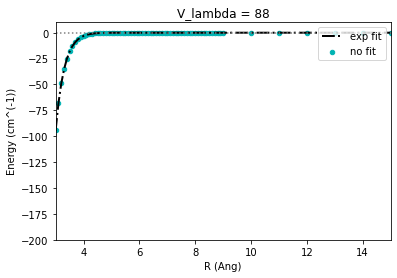

Double exponential RMSE =  3.944263177158361e-12
[[12  6 14]]
[ 2.20501322e+01 -8.87096907e+03  9.12212792e+05]


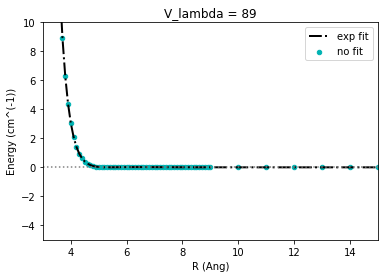

Double exponential RMSE =  3.315716356522915e-12
[[12  6 16]]
[-2.30920026e+01  9.31536743e+03 -9.57015216e+05]


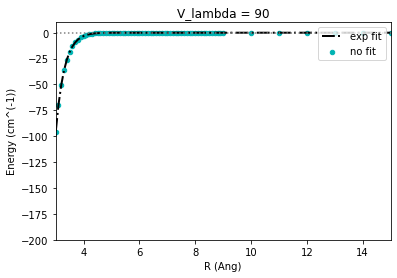

Double exponential RMSE =  1.1453026540059982e-12
[[12  6 18]]
[ 2.99688510e+01 -1.21223431e+04  1.24393001e+06]


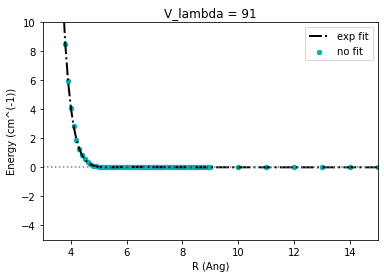

Double exponential RMSE =  1.0601148730672236e-12
Average fit RMSE =  2.543142364135738e-12


In [22]:
for i in range(0,lm):
    j=int(i)
    y_dummy = df_Vnf[j]
    strt=15     # starting point for fit (choose carefully to avoid bad fit near minimas)
    parsx, covx = curve_fit(f=exp_fit, xdata=x_dummy[strt:], ydata=y_dummy[strt:], p0=[0,0,1000])
    a[j],b[j],c[j] = parsx
    print("Radial coefficient [l1 l2 l]: ", Lmat[i])
    print("Fitting coefficients for exp_fit function [a b c]: ",parsx)
    # Plot the fit data as an overlay on the scatter data
    plt.scatter(x_dummy, y_dummy,s=20, color='#00b3b3',label = 'no fit')
    xdummy=np.arange(2.5,15.1,0.1)
    plt.plot(xdummy, exp_fit(xdummy, *parsx), linestyle='-.', linewidth=2, color='black', label = 'exp fit')
    plt.legend(loc="upper right")
    plt.ylabel("Energy (cm^(-1))")
    plt.xlabel("R (Ang)")
    plt.axhline(y=0, color='grey', linestyle=':')
    plt.title("V_lambda = %d" %(i))
    plt.ylim(max(y_dummy.min()-5,-200), 10)
    plt.xlim(3, 15)
    plt.show()
    print('Double exponential RMSE = ',np.sqrt(np.average(np.power((exp_fit(x_dummy, *parsx) - y_dummy),2))))
    rmsx[j]=np.sqrt(np.average(np.power((exp_fit(x_dummy, *parsx) - y_dummy),2)))
print('Average fit RMSE = ',np.average(rmsx))

In [23]:
# save output for each V lambdas as required by molscat!
print('LAMBDA ='),
for j in range (lm):
    print(Lmat[j,0],',',Lmat[j,1],',',Lmat[j,2],',')
print('NTERM  = ', '3,'*lm)
print('NPOWER = ', '0,'*int(lm*3))
print('A      = ')
for j in range (lm):
    print(a[j],',',b[j],',',c[j],',')
print('E      =', '-1,-2,-3,'*lm) # change as per funtion taken above

LAMBDA =
0 , 0 , 0 ,
0 , 2 , 2 ,
0 , 4 , 4 ,
0 , 6 , 6 ,
2 , 0 , 2 ,
2 , 2 , 0 ,
2 , 2 , 2 ,
2 , 2 , 4 ,
2 , 4 , 2 ,
2 , 4 , 4 ,
2 , 4 , 6 ,
2 , 6 , 4 ,
2 , 6 , 6 ,
2 , 6 , 8 ,
4 , 0 , 4 ,
4 , 2 , 2 ,
4 , 2 , 4 ,
4 , 2 , 6 ,
4 , 4 , 0 ,
4 , 4 , 2 ,
4 , 4 , 4 ,
4 , 4 , 6 ,
4 , 4 , 8 ,
4 , 6 , 2 ,
4 , 6 , 4 ,
4 , 6 , 6 ,
4 , 6 , 8 ,
4 , 6 , 10 ,
6 , 0 , 6 ,
6 , 2 , 4 ,
6 , 2 , 6 ,
6 , 2 , 8 ,
6 , 4 , 2 ,
6 , 4 , 4 ,
6 , 4 , 6 ,
6 , 4 , 8 ,
6 , 4 , 10 ,
6 , 6 , 0 ,
6 , 6 , 2 ,
6 , 6 , 4 ,
6 , 6 , 6 ,
6 , 6 , 8 ,
6 , 6 , 10 ,
6 , 6 , 12 ,
8 , 0 , 8 ,
8 , 2 , 6 ,
8 , 2 , 8 ,
8 , 2 , 10 ,
8 , 4 , 4 ,
8 , 4 , 6 ,
8 , 4 , 8 ,
8 , 4 , 10 ,
8 , 4 , 12 ,
8 , 6 , 2 ,
8 , 6 , 4 ,
8 , 6 , 6 ,
8 , 6 , 8 ,
8 , 6 , 10 ,
8 , 6 , 12 ,
8 , 6 , 14 ,
10 , 0 , 10 ,
10 , 2 , 8 ,
10 , 2 , 10 ,
10 , 2 , 12 ,
10 , 4 , 6 ,
10 , 4 , 8 ,
10 , 4 , 10 ,
10 , 4 , 12 ,
10 , 4 , 14 ,
10 , 6 , 4 ,
10 , 6 , 6 ,
10 , 6 , 8 ,
10 , 6 , 10 ,
10 , 6 , 12 ,
10 , 6 , 14 ,
10 , 6 , 16 ,
12 , 0 , 12 ,
12 , 2 , 10 ,
12 , 2 , 12 ,
1